# Goddard problem (julia with InfiniteOpt)

<img src="goddard.jpg" width=417 height=512>

[Thumbnail](goddard.jpg)

This well-known problem (see for instance [1],[2]) models the ascent of a rocket through the atmosphere, and we restrict here ourselves to  vertical (monodimensional) trajectories.
The state variables are the altitude, speed and mass of the rocket during the flight, for a total dimension of 3. 
The rocket is subject to gravity, thrust and drag forces. The final time is fixed, and the objective is to reach a maximal altitude with a prescribed fuel consumption, ie a fixed final mass. 

$$
\left \lbrace
\begin{array}{l}
\displaystyle\max\limits_{x,u,T}\ r(T)\\
\dot r = v\\
\dot v = \displaystyle\frac{T_{max} u - D(r,v)}{m} - \frac{1}{r^2}\\
\dot m = - \displaystyle\frac{b}{T_{max}} u\\
u(\cdot) \in [0,1]\\ 
v(\cdot) \in [0,1]\\
r(0)=0,\ v(0)=0,\ m(0)=1\\
m(T) = 0.6\\
\end{array}
\right .
$$

The drag term is a function of speed and altitude defined as 
$D(r,v)=\alpha v^2\rho(r)$,
with the volumic mass given by the approximate model 
$\rho(r)=e^{-\beta (r -1)}$.

In the following we use the parameters 
$\alpha=310,\beta=500, b=2.0, T_{max}=3.5$.

The Hamiltonian is an affine function of the control, so singular arcs may occur.

**References**

1. R.H. Goddard. A Method of Reaching Extreme Altitudes, volume 71(2) of Smithsonian Miscellaneous Collections. Smithsonian institution, City of Washington, 1919.

2. H. Seywald and E.M. Cliff. Goddard problem in presence of a dynamic pressure limit. Journal of Guidance, Control, and Dynamics, 16(4):776–781, 1993.
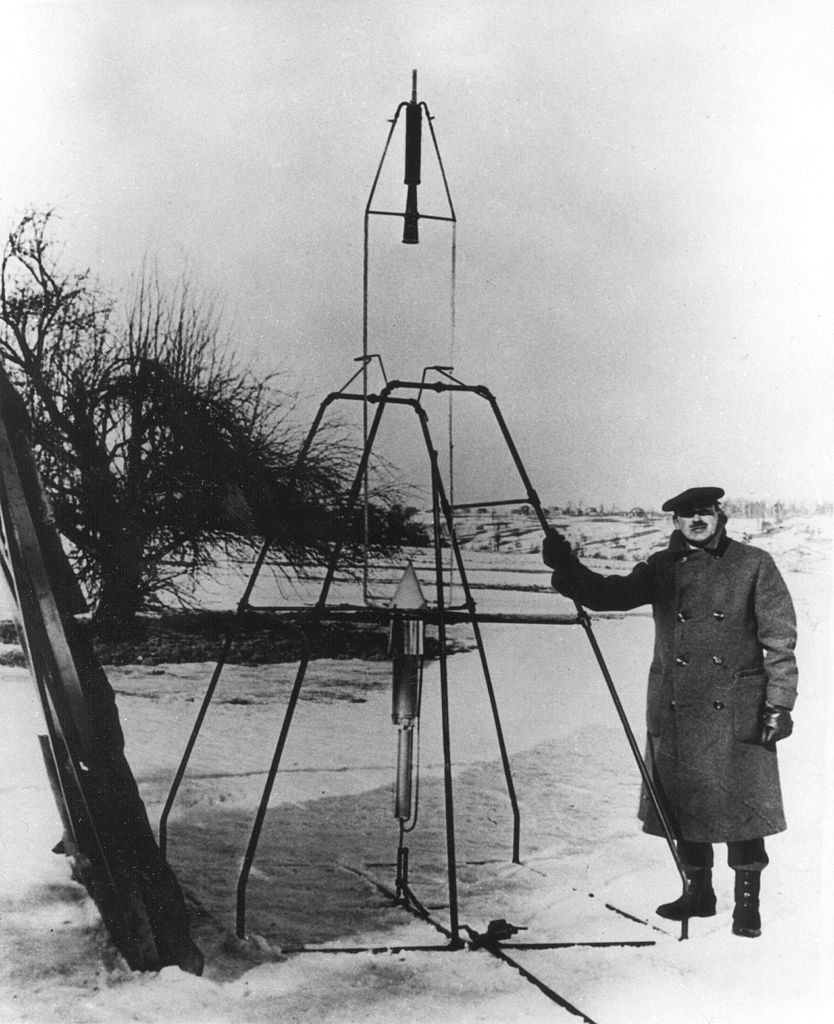

## Imports

In [1]:
### Goddard problem with InfiniteOpt package

using Plots
using InfiniteOpt, Ipopt, MINPACK

## Functions & parameters definition

In [2]:
struct OCP
    f_0 ::Function
    f_1 ::Function
    control_bounds ::Tuple{Number,Number}
    g ::Union{Function,Nothing}
end

In [3]:
function direct_solve(ocp,x0,x3f)
    # Inputs
    F0 = ocp.f_0
    F1 = ocp.f_1
    umin = ocp.control_bounds[1]
    umax = ocp.control_bounds[2]
    g = ocp.g
    r0,v0,m0 = x0
    mf = x3f

    # create model
    goddard = InfiniteModel(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 3));

    set_optimizer_attribute(goddard,"tol",1e-8)
    set_optimizer_attribute(goddard,"constr_viol_tol",1e-6)
    set_optimizer_attribute(goddard,"max_iter",1000)


    # independent variables (normalized time since final time T is free)
    @infinite_parameter(goddard, t in [0, 1], num_supports = N+1)

    set_all_derivative_methods(goddard, FiniteDifference(Forward()))

    @variables(goddard,begin
            0 <= T
            # state variables
            r0 <= r <= Inf, Infinite(t)
            v0 <= v <= Inf , Infinite(t)
            mf <= m <= m0, Infinite(t)
            # control variables
            umin <= u <= umax, Infinite(t)
    end)

    x = [r,v,m]
    F0_r,F0_v,F0_m = F0(x)
    F1_r,F1_v,F1_m = F1(x)


    # objective: maximize final altitude
    @objective(goddard, Max, r(1));

    # boundary conditions
    @constraints(goddard,begin
            con_x0, [x[i](0) for i in 1:3] .== x0
            g(x) >= 0
    end)

    # dynamics (with time normalization)

    d_r, d_v, d_m = [@deriv(r,t),@deriv(v,t),@deriv(m,t)]
   
    evaluate_all_derivatives!(goddard)
    
    @constraints(goddard,begin
            d_r == T * (F0_r + u * F1_r)
            d_v == T * (F0_v + u * F1_v)
            d_m == T * (F0_m + u * F1_m)    
    end)

   
    
    status = optimize!(goddard)

    if termination_status(goddard) == MOI.OPTIMAL
        println("Solution is optimal")
    elseif termination_status(goddard) == MOI.LOCALLY_SOLVED
        println("Local solution found")
    elseif termination_status(goddard) == MOI.TIME_LIMIT && has_values(sys)
        println("Solution is suboptimal due to a time limit, but a primal solution is available")
    else
        error("The model was not solved correctly.")
    end
    
    T_opt = value.(T);
    t = value.(t) ;t = (t[1:end-1] + t[2:end])/2.0
    t = t*T_opt
    r_opt = value.(r); r_opt = (r_opt[1:end-1] + r_opt[2:end])/2.0
    v_opt = value.(v); v_opt = (v_opt[1:end-1] + v_opt[2:end])/2.0
    m_opt = value.(m); m_opt = (m_opt[1:end-1] + m_opt[2:end])/2.0
    u_opt = value.(u); u_opt = (u_opt[1:end-1] + u_opt[2:end])/2.0
    x =  [ [ r_opt[i], v_opt[i], m_opt[i] ] for i in 1:N ]

    p = [  [ dual(derivative_constraints(d_r)[i]), dual(derivative_constraints(d_v)[i]), dual(derivative_constraints(d_m)[i]) ] for i in 1:N ]
    return t,x,u_opt,p
end;

In [4]:
include("flow.jl")

function indirect_solve(ocp,x0,x3f,ξ)
    # Inputs
    F0 = ocp.f_0
    F1 = ocp.f_1
    g = ocp.g
    r0,v0,m0 = x0
    mf = x3f  

    # Computation of singular control of order 1
    H0(x, p) = p' * F0(x) 
    H1(x, p) = p' * F1(x)
    H01 = Poisson(H0, H1)
    H001 = Poisson(H0, H01)
    H101 = Poisson(H1, H01)
    us(x, p) = -H001(x, p)/H101(x, p)

    # Computation of boundary control
    c(x) = -g(x) # v - vmax ≤ 0

    ub(x) = -Lie(F0, c)(x) / Lie(F1, c)(x)
    μb(x, p) = -H01(x, p) / Lie(F1, c)(x)

    # Hamiltonians (regular, singular, boundary) and associated flows
    H(x, p, u, μ) = H0(x, p) + u*H1(x, p) - μ*c(x)
    Hr(x, p) = H(x, p, 1.0, 0.0)
    Hs(x, p) = H(x, p, us(x, p), 0.0)
    Hb(x, p) = H(x, p, ub(x), μb(x, p))

    f0 = Flow(H0)
    fr = Flow(Hr)
    fs = Flow(Hs)
    fb = Flow(Hb);
    
    # Shooting function
    function shoot(p0, t1, t2, t3, tf) # B+ S C B0 structure

        x1, p1 = fr(t0, x0, p0, t1)
        x2, p2 = fs(t1, x1, p1, t2)
        x3, p3 = fb(t2, x2, p2, t3)
        xf, pf = f0(t3, x3, p3, tf)
        s = zeros(eltype(p0), 7)
        s[1:2] = pf[1:2] - [ 1.0, 0.0 ]
        s[3] = xf[3] - mf # supposed to be active
        s[4] = H1(x1, p1)
        s[5] = H01(x1, p1)
        s[6] = c(x2)
        s[7] = H0(xf, pf) # free tf

        return s

    end
    
    # Solve
    foo(ξ) = shoot(ξ[1:3], ξ[4], ξ[5], ξ[6], ξ[7])
    jfoo(ξ) = ForwardDiff.jacobian(foo, ξ)
    foo!(s, ξ) = ( s[:] = foo(ξ); nothing )
    jfoo!(js, ξ) = ( js[:] = jfoo(ξ); nothing )

    println("Initial value of shooting:\n", foo(ξ), "\n\n")

    #nl_sol = fsolve(foo!, jfoo!, ξ, show_trace=true); println(nl_sol)
    nl_sol = fsolve(foo!, ξ, show_trace=true); println(nl_sol)


    # Retrieves solution
    if nl_sol.converged
        p0 = nl_sol.x[1:3]
        t1 = nl_sol.x[4]
        t2 = nl_sol.x[5]
        t3 = nl_sol.x[6]
        tf = nl_sol.x[7];
    else
        error("Not converged")
    end
    
    # Outputs
    ode_sol = fr((t0, t1), x0, p0)
    tt0 = ode_sol.t
    xx0 = [ ode_sol[1:3, j] for j in 1:size(tt0, 1) ]
    pp0 = [ ode_sol[4:6, j] for j in 1:size(tt0, 1) ]
    uu0 = ones(size(tt0, 1))
    μ0  = zeros(size(tt0, 1))

    ode_sol = fs((t1, t2), xx0[end], pp0[end])
    tt1 = ode_sol.t
    xx1 = [ ode_sol[1:3, j] for j in 1:size(tt1, 1) ]
    pp1 = [ ode_sol[4:6, j] for j in 1:size(tt1, 1) ]
    uu1 = us.(xx1, pp1)
    μ1  = zeros(size(tt1, 1))

    ode_sol = fb((t2, t3), xx1[end], pp1[end])
    tt2 = ode_sol.t
    xx2 = [ ode_sol[1:3, j] for j in 1:size(tt2, 1) ]
    pp2 = [ ode_sol[4:6, j] for j in 1:size(tt2, 1) ]
    uu2 = ub.(xx2)
    μ2  = μb.(xx2, pp2)

    ode_sol = f0((t3, tf), xx2[end], pp2[end])
    tt3 = ode_sol.t
    xx3 = [ ode_sol[1:3, j] for j in 1:size(tt3, 1) ]
    pp3 = [ ode_sol[4:6, j] for j in 1:size(tt3, 1) ]
    uu3 = zeros(size(tt3, 1))
    μ3  = zeros(size(tt3, 1))

    t = [ tt0 ; tt1 ; tt2 ; tt3 ]
    x = [ xx0 ; xx1 ; xx2 ; xx3 ]
    p = [ pp0 ; pp1 ; pp2 ; pp3 ]
    u = [ uu0 ; uu1 ; uu2 ; uu3 ]
    μ = [ μ0  ; μ1  ; μ2  ; μ3  ]
    
    return t,x,p,u,μ,nl_sol
end;

## Problem definition

In [5]:
# define parameters
𝛼 = 310.0;
𝑇𝑚𝑎𝑥 = 3.5;
β = 500.0;
b = 2.0;
N = 1000;
t0 = 0.0;
r0 = 1.0;
v0 = 0.0;
vmax = 0.1;
m0 = 1.0;
mf = 0.6;
x0 = [ r0, v0, m0 ]

# Create dynamics functions
# not depending on control
function F0(x)
    r, v, m = x
    D = 𝛼 * v^2 * exp(-β*(r-1.0))
    F = [ v, -D/m-1.0/r^2, 0.0 ]
    return F
end

# lineary dependent on control
function F1(x)
    r, v, m = x
    F = [ 0.0, 𝑇𝑚𝑎𝑥/m, -b*𝑇𝑚𝑎𝑥 ]
    return F
end

# state constraints
g(x) = vmax - x[2]

# generic optimal control problem
ocp = OCP(F0,F1,(0,1),g);

## Direct solve

In [6]:
t,x,u,p = direct_solve(ocp,x0,mf);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:     7008
                     variables with only lower bounds:     2003
                variables with lower and upper bounds:     2002
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6006
Total number of inequality constraints...............:     1001
        inequality constraints with only lower bounds:     1001
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 36

     

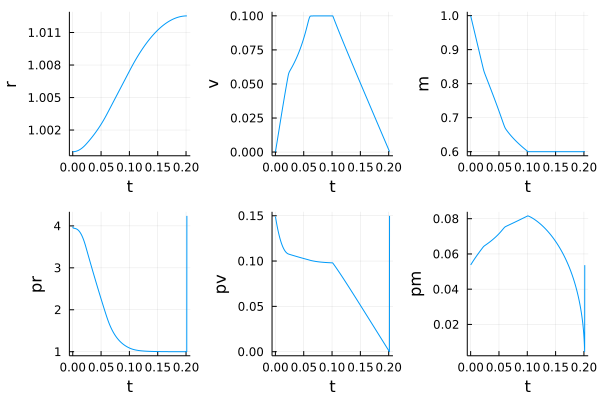

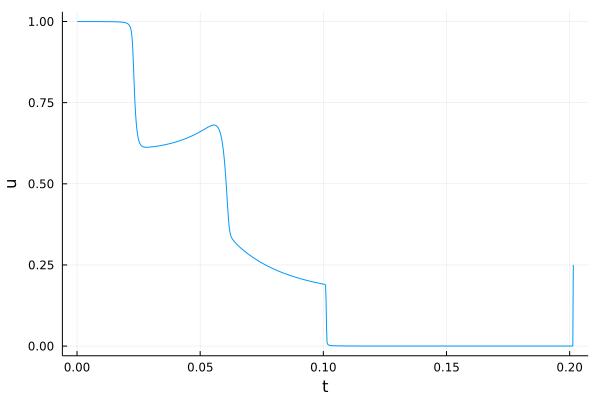

In [7]:
#plot solution

#timesteps = supports(t) * T_opt
p1 = plot(t, [ x[i][1] for i in 1:N],xlabel = "t", ylabel = "r",legend = false)
p2 = plot(t, [ x[i][2] for i in 1:N],xlabel = "t", ylabel = "v",legend = false)
p3 = plot(t, [ x[i][3] for i in 1:N],xlabel = "t", ylabel = "m",legend = false)
p4 = plot(t, u,xlabel = "t", ylabel = "u",legend = false)

pr_plot = plot(t[1:N], [ p[i][1] for i in 1:N ], xlabel = "t", ylabel = "pr", legend = false, fmt = :png)
pv_plot = plot(t[1:N], [ p[i][2] for i in 1:N ], xlabel = "t", ylabel = "pv", legend = false, fmt = :png)
pm_plot = plot(t[1:N], [ p[i][3] for i in 1:N ], xlabel = "t", ylabel = "pm", legend = false, fmt = :png)
display(plot(p1,p2,p3,pr_plot,pv_plot,pm_plot,layout = (2,3)))
display(p4)

## Indirect Solve

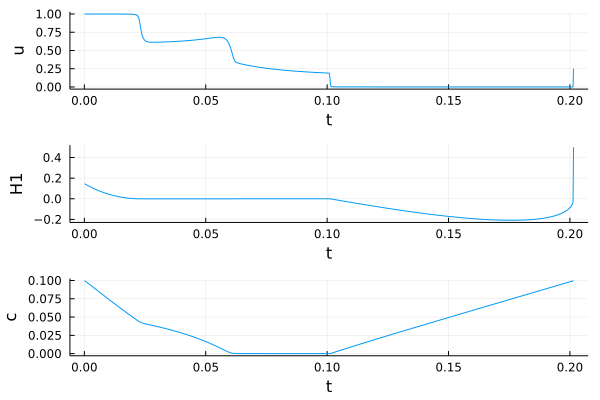

Initial guess:
[3.9873218217007644, 0.14903390201683928, 0.053755257563987024, 0.020864154065444274, 0.06057660190015463, 0.10210332400142536, 0.20148523660301018]


In [8]:
H1 = [p[i]' * ocp.f_1(x[i]) for i in 1:N]

# Initialisation
H1_plot = plot(t, H1, xlabel = "t", ylabel = "H1", legend = false, fmt = :png)
c_plot = plot(t, [ocp.g(x[i]) for i in 1:N], xlabel = "t", ylabel = "c", legend = false, fmt = :png)
display(plot(p4, H1_plot, c_plot, layout = (3,1)))
η = 1e-3
t13 = t[ abs.(H1) .≤ η ]
t23 = t[ 0 .≤ [ocp.g(x[i]) for i in 1:N] .≤ η ]
p0 = p[1]
t1 = min(t13...)
t2 = min(t23...)
t3 = max(t23...)
tf = t[end]
ξ = [ p0 ; t1 ; t2 ; t3 ; tf ]

println("Initial guess:\n", ξ)

In [9]:
t,x,p,u,μ,nl_sol = indirect_solve(ocp,x0,mf,ξ);

Initial value of shooting:
[0.10632993546850322, -0.016638439575299778, -0.01432380424805757, -0.009847202629801599, -1.8570799457791738, 0.009212091352772803, 0.031983609424198506]


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.857080e+00     0.000000e+00         0.541502
     2     7.507845e-02     1.405972e-02         2.447854
     3     3.651025e-02     2.563543e-03         0.195139
     4     4.141598e-03     7.497192e-04         0.200445
     5     2.237185e-04     1.509031e-06         0.181333
     6     1.096946e-04     3.666225e-08         0.242218
     7     1.486693e-05     4.917778e-09         0.184823
     8     3.645984e-06     1.141170e-12         0.193889
     9     8.622804e-08     1.271840e-13         0.256596
    10     9.609389e-08     1.390604e-15         0.195562
    11     1.757629e-08     6.393690e-17         0.181340
    12     3.816976e-09     2.049103e-18         0.195741
Results o

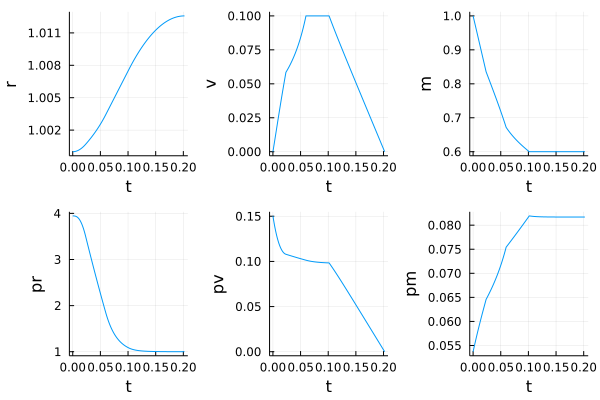

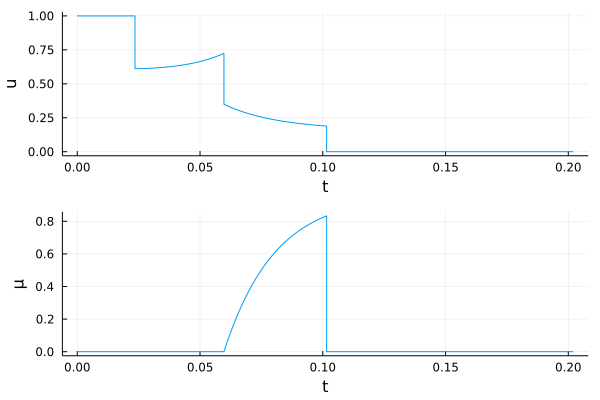

In [10]:
# Plots
N = length(t)
r_plot  = plot(t, [ x[i][1] for i=1:N ], xlabel = "t", ylabel = "r", legend = false, fmt = :png)
v_plot  = plot(t, [ x[i][2] for i=1:N ], xlabel = "t", ylabel = "v", legend = false, fmt = :png)
m_plot  = plot(t, [ x[i][3] for i=1:N ], xlabel = "t", ylabel = "m", legend = false, fmt = :png)
pr_plot = plot(t, [ p[i][1] for i=1:N ], xlabel = "t", ylabel = "pr", legend = false, fmt = :png)
pv_plot = plot(t, [ p[i][2] for i=1:N ], xlabel = "t", ylabel = "pv", legend = false, fmt = :png)
pm_plot = plot(t, [ p[i][3] for i=1:N ], xlabel = "t", ylabel = "pm", legend = false, fmt = :png)
u_plot  = plot(t, u, xlabel = "t", ylabel = "u", legend = false, fmt = :png)
μ_plot  = plot(t, μ, xlabel = "t", ylabel = "μ", legend = false, fmt = :png)
display(plot(r_plot, v_plot, m_plot, pr_plot, pv_plot, pm_plot, layout = (2,3)))
display(plot(u_plot, μ_plot, layout = (2,1)))